In [1]:
import cv2
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

from src.image_processing import ImageProcessor

In [2]:
def show(image):
    plt.imshow(image, cmap='gray')
    _ = plt.axis('off')
    plt.show()

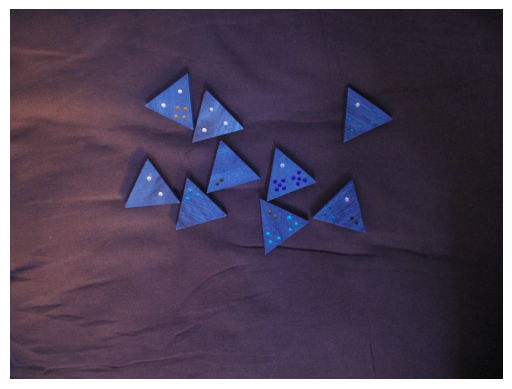

In [247]:
image = cv2.imread('./images/Pict_2_2.bmp')
#image = cv2.cvtColor(image_orig, cv2.COLOR_BGR2GRAY)
#image = cv2.GaussianBlur(image, (5, 5), 0)
show(image)

In [4]:
np.mean(image[200:220, 343:350], axis=(0, 1)), np.std(image[200:220, 343:350], axis=(0, 1))

(array([ 68.65714286,  76.91428571, 128.96428571]),
 array([26.932925 , 38.9557415, 57.5330229]))

In [6]:
proc = ImageProcessor(image)
centr, contr = proc.segmentate_objects()

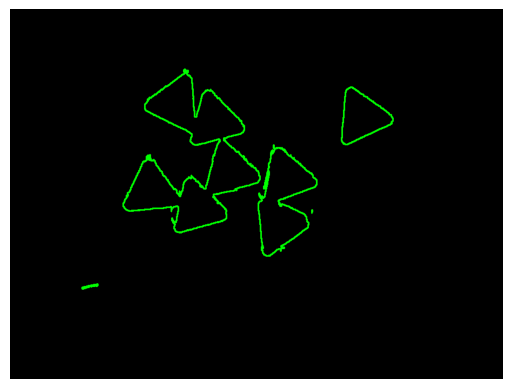

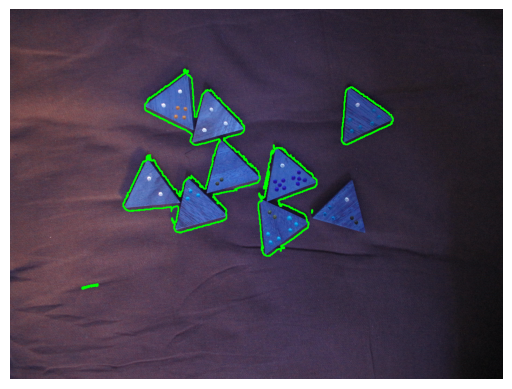

In [7]:
output_mask = np.zeros_like(image)
output_image = image.copy()
cv2.drawContours(output_image, contr, -1, (0, 255, 0), 2)
cv2.drawContours(output_mask, contr, -1, (0, 255, 0), 2)
show(output_mask)
show(output_image)

In [60]:
def find_contours(image):
    # Find contours
    contours, _ = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    return contours

In [360]:
def count_dots(contour):
    # Approximate the contour to a polygon
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.05 * peri, True)
    
    # If the polygon has 3 vertices, it's a triangle
    if len(approx) == 3:
        # Compute centroid of the contour
        M = cv2.moments(contour)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        return (cx, cy), approx

    return None, None

In [469]:
def preprocess_image(image):
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(30, 30))
    image = clahe.apply(image)

    # Apply Gaussian blur to remove noise
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = cv2.medianBlur(image, 15)

    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    #_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

    #show(thresh)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, (3, 3), iterations=2)
    #thresh = cv2.erode(thresh, (3, 3), iterations=2)
    thresh = cv2.dilate(thresh, (5, 5), iterations=2)
    show(thresh)

    return thresh

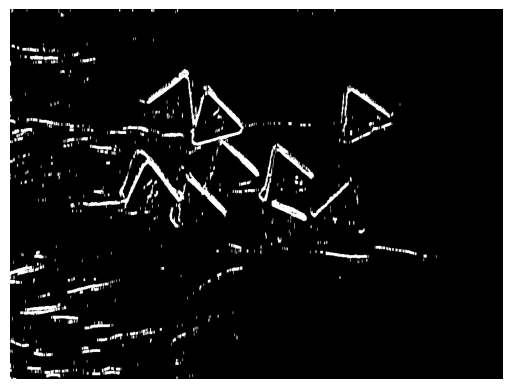

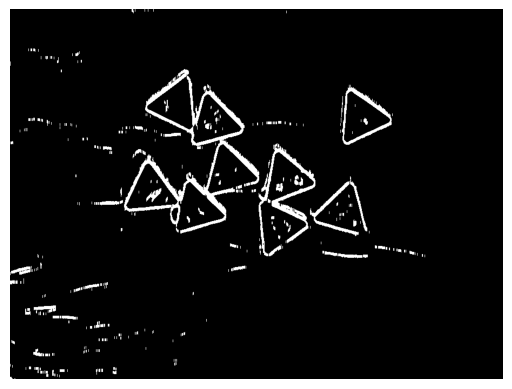

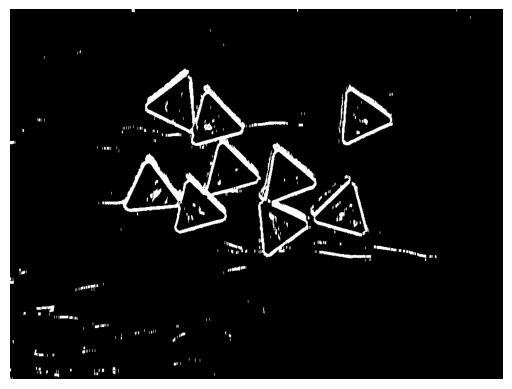

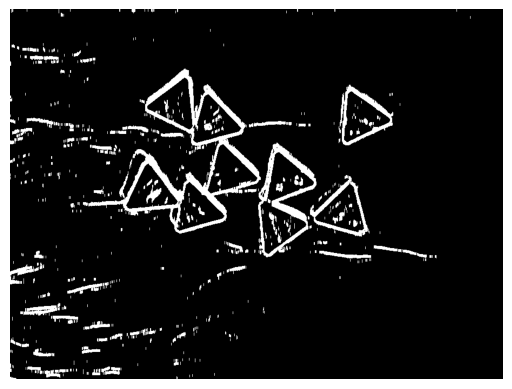

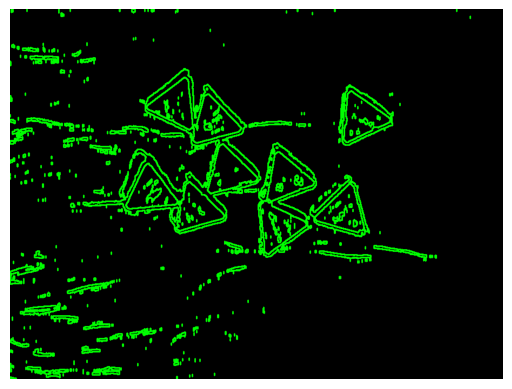

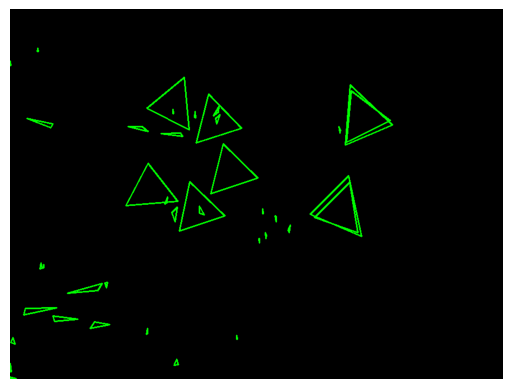

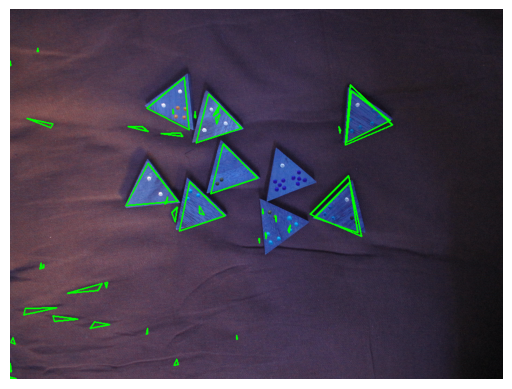

In [470]:
# Preprocess the image
output_image = None
for ch in cv2.split(image):
    if output_image is None:
        output_image = np.zeros_like(ch)
    processed_image = preprocess_image(ch)
    output_image = cv2.bitwise_or(output_image, processed_image)
#output_image = cv2.morphologyEx(output_image, cv2.MORPH_OPEN, (3, 3), iterations=5)
#output_image = cv2.erode(output_image, (3, 3), iterations=1)
show(output_image)
# Find contours
contours = find_contours(output_image.copy())

output_mask = np.zeros_like(image)
cv2.drawContours(output_mask, contours, -1, (0, 255, 0), 2)
show(output_mask)

# Create a copy of the original image to draw results
output_mask = np.zeros_like(image)
output_image = image.copy()

# List to store centroids and dot counts
centroids_validated = []
contours_validated = []

for contour in contours:
    dot_coords, approx = count_dots(contour)
    if dot_coords:
        centroids_validated.append(dot_coords)
        contours_validated.append(approx)
cv2.drawContours(output_image, contours_validated, -1, (0, 255, 0), 2)
cv2.drawContours(output_mask, contours_validated, -1, (0, 255, 0), 2)
show(output_mask)
show(output_image)

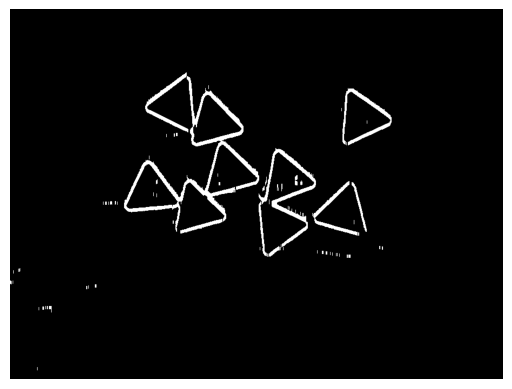

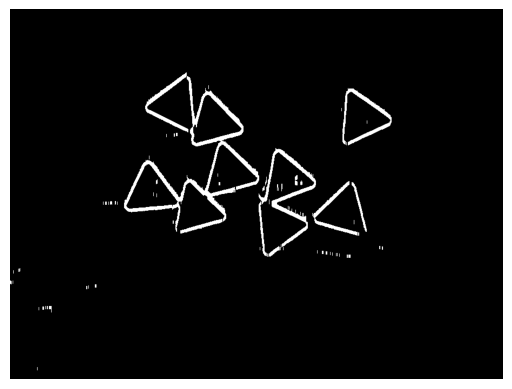

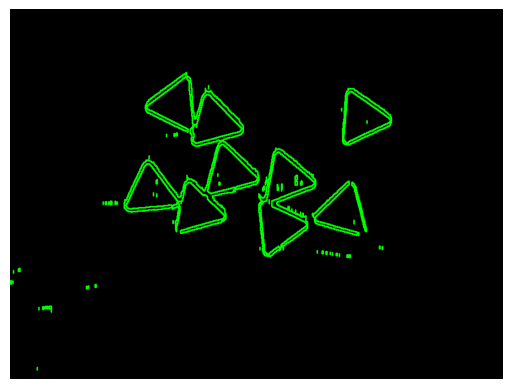

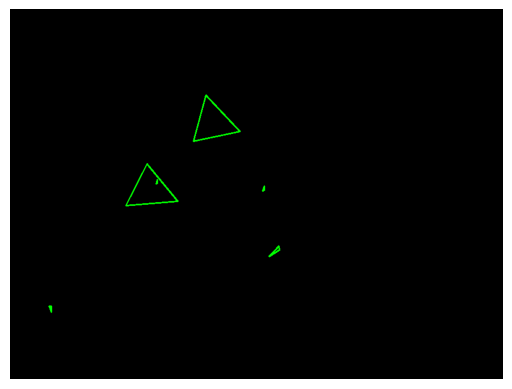

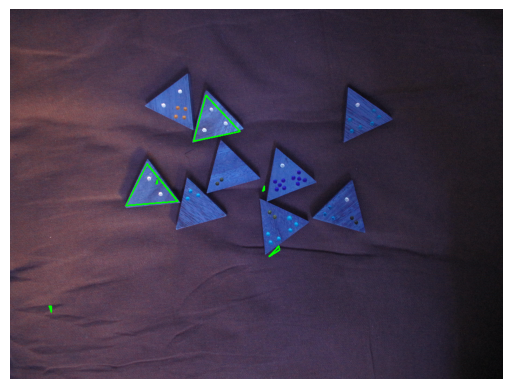

In [344]:
# Preprocess the image
output_image = preprocess_image(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
#output_image = cv2.morphologyEx(output_image, cv2.MORPH_OPEN, (3, 3), iterations=1)
#output_image = cv2.dilate(output_image, (15, 15), iterations=8)
show(output_image)
# Find contours
contours = find_contours(output_image.copy())

output_mask = np.zeros_like(image)
cv2.drawContours(output_mask, contours, -1, (0, 255, 0), 2)
show(output_mask)

# Create a copy of the original image to draw results
output_mask = np.zeros_like(image)
output_image = image.copy()

# List to store centroids and dot counts
centroids_validated = []
contours_validated = []

for contour in contours:
    dot_coords, approx = count_dots(contour)
    if dot_coords:
        centroids_validated.append(dot_coords)
        contours_validated.append(approx)
cv2.drawContours(output_image, contours_validated, -1, (0, 255, 0), 2)
cv2.drawContours(output_mask, contours_validated, -1, (0, 255, 0), 2)
show(output_mask)
show(output_image)

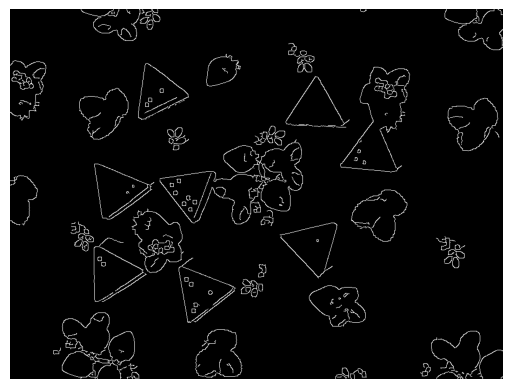

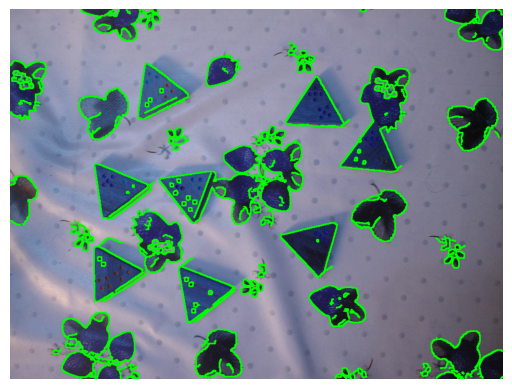

In [245]:
image_orig = cv2.imread('./images/Pict_3_2.bmp')
image = cv2.cvtColor(image_orig, cv2.COLOR_BGR2GRAY)
image = cv2.GaussianBlur(image, (5, 5), 0)
image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))

edges = cv2.Canny(image, 50, 100)
show(edges)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# create a blank mask to store the segmented objects
mask = image_orig.copy()
fill_color = (0, 255, 0)

cv2.drawContours(mask, contours, -1, fill_color, 2)
show(mask)

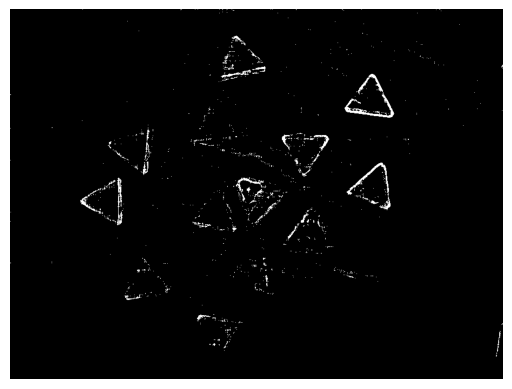

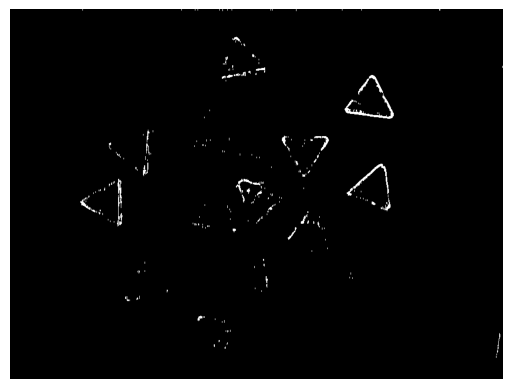

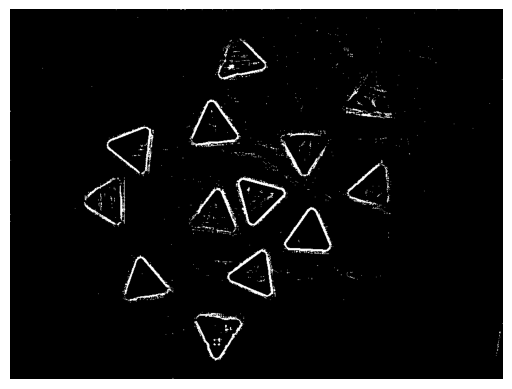

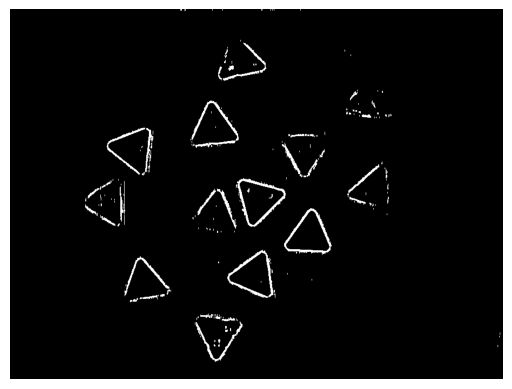

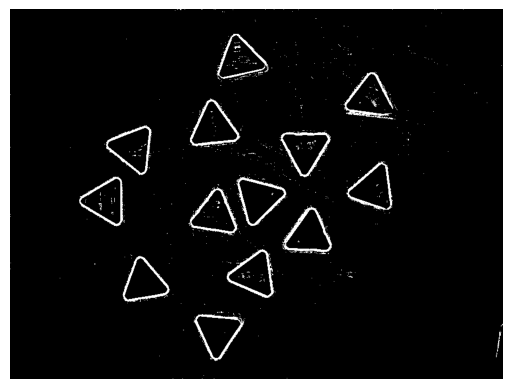

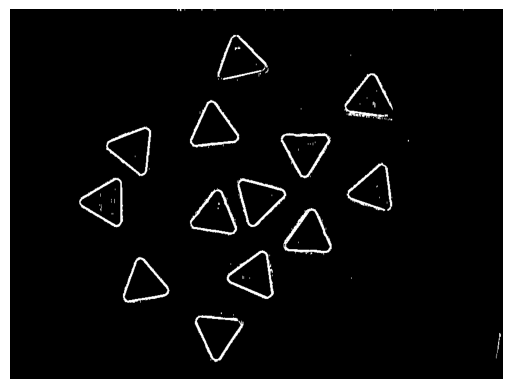

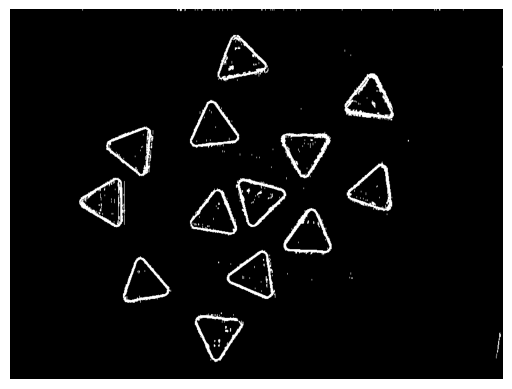

In [463]:
output_image = None
for ch in cv2.split(image):
    if output_image is None:
        output_image = np.zeros_like(ch)
    processed_image = preprocess_image(ch)
    output_image = cv2.bitwise_or(output_image, processed_image)
show(output_image)

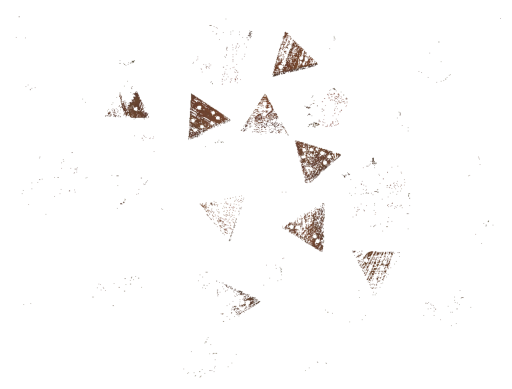

In [65]:
def set_default_color(image, target_color, threshold, default_color):
    
    # Define lower and upper bounds for the target color in LAB color space
    lower_bound = (target_color - threshold).astype(np.uint8)
    upper_bound = (target_color + threshold).astype(np.uint8)
    
    # Create a mask for pixels within the target color range
    mask = cv2.inRange(image, lower_bound, upper_bound)

    # Invert the mask
    mask = cv2.bitwise_not(mask)

    # Set the color of pixels outside the target color range to default color
    image[mask == 255] = default_color
    
    return image

target_color = np.array((107, 69, 48))
threshold = np.array((30, 10, 10))
default_color = np.array((255, 255, 255))
show(set_default_color(image.copy(), target_color, threshold, default_color))

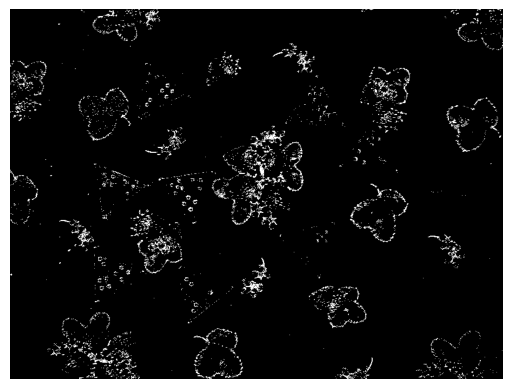

In [405]:
# Split image into channels
b, g, r = cv2.split(image_orig)

# Compute absolute differences for each channel
diff_b = cv2.absdiff(b, cv2.medianBlur(b, 5))
diff_g = cv2.absdiff(g, cv2.medianBlur(g, 5))
diff_r = cv2.absdiff(r, cv2.medianBlur(r, 5))

# Combine differences
diff = cv2.bitwise_or(cv2.bitwise_or(diff_b, diff_g), diff_r)

# Threshold the combined difference image
_, thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_OTSU)
show(thresh)